In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.stats.multitest import multipletests

In [2]:
# Imports the data that are saved in "statsbomb_data":
import json

with open('statsbomb_data.json') as file:
    statsbomb_data = json.load(file)

In [3]:
# Unpacks the data and re-converts dictionaries to data frames:
print(statsbomb_data.keys())

competitions = pd.DataFrame(statsbomb_data['competitions'])

matches = statsbomb_data['matches']
for key, value in matches.items():
    matches[key] = pd.DataFrame(value)

events = statsbomb_data['events']
for key, value in events.items():
    value['data'] = pd.DataFrame(value['data'])

dict_keys(['competitions', 'matches', 'events'])


In [4]:
# Fixes lengths that are shorter than regular playtime:
for value in events.values():
    if value['data'].length_half1.unique()[0] < 45:
        value['data'].length_half1 = 45
    if value['data'].length_match.unique()[0] == 90:
        value['data'].length_match = 91
    if value['data'].length_match.unique()[0] < 90:
        value['data'].length_match = 90

In [5]:
# Function that gets the time spans during which a team leads or there is a draw:
def min_lead(match):
    shot_frame = match['data']
    frame = shot_frame[(shot_frame.outcome == 'Goal') | (shot_frame.outcome == 'Own Goal')].reset_index(drop=True)
    length_draw = 0
    length_home_team = 0
    length_away_team = 0
    length_half1 = shot_frame['length_half1'].max()
    length_match = shot_frame['length_match'].max()
    winner = match['winner']
    for shot_id in frame.index:
        if shot_id == 0:
            if frame.iloc[shot_id].half == 1:
                length_draw += frame.iloc[0].minute
            elif frame.iloc[shot_id].half == 2:
                length_draw += frame.iloc[0].minute - 45 + length_half1
        elif frame.iloc[shot_id].half == 2 and frame.iloc[shot_id - 1].half == 1:
            if frame.iloc[shot_id].leader == home_team:
                length_home_team += frame.iloc[shot_id].minute - 45 + length_half1 - frame.iloc[shot_id - 1].minute
            elif frame.iloc[shot_id].leader == away_team:
                length_away_team += frame.iloc[shot_id].minute - 45 + length_half1 - frame.iloc[shot_id - 1].minute
            elif frame.iloc[shot_id].leader == 'draw':
                length_draw += frame.iloc[shot_id].minute - 45 + length_half1 - frame.iloc[shot_id - 1].minute           
        else:
            if frame.iloc[shot_id].leader == home_team:
                length_home_team += frame.iloc[shot_id].minute - frame.iloc[shot_id - 1].minute
            elif frame.iloc[shot_id].leader == away_team:
                length_away_team += frame.iloc[shot_id].minute - frame.iloc[shot_id - 1].minute
            elif frame.iloc[shot_id].leader == 'draw':
                length_draw += frame.iloc[shot_id].minute - frame.iloc[shot_id - 1].minute
    if winner == home_team:
        length_home_team += length_match - frame.minute.max()
    elif winner == away_team:
        length_away_team += length_match - frame.minute.max()
    elif winner == 'draw':
        if match['home_score'] == 0 and match['away_score'] == 0:
            length_draw = length_match - 45 + length_half1
        else:
            length_draw += length_match - frame.minute.max()
    return length_home_team, length_away_team, length_draw

In [6]:
# Function that gets the xG values that occur while a team leads or there is a draw:
def get_xG(match):
    home_team_xG_home_team_lead = 0
    home_team_xG_away_team_lead = 0
    home_team_xG_draw = 0
    away_team_xG_home_team_lead = 0
    away_team_xG_away_team_lead = 0
    away_team_xG_draw = 0
    int_list = [int(shot_id) for shot_id in match.index]
    
    for shot_id in int_list:
        if match.iloc[shot_id].outcome == 'Own Goal':
            continue
        elif match.iloc[shot_id].team == home_team and match.iloc[shot_id].leader == home_team:
            home_team_xG_home_team_lead += match.iloc[shot_id].xG
        elif match.iloc[shot_id].team == home_team and match.iloc[shot_id].leader == away_team:
            home_team_xG_away_team_lead += match.iloc[shot_id].xG
        elif match.iloc[shot_id].team == home_team and match.iloc[shot_id].leader == 'draw':
            home_team_xG_draw += match.iloc[shot_id].xG
        elif match.iloc[shot_id].team == away_team and match.iloc[shot_id].leader == home_team:
            away_team_xG_home_team_lead += match.iloc[shot_id].xG
        elif match.iloc[shot_id].team == away_team and match.iloc[shot_id].leader == away_team:
            away_team_xG_away_team_lead += match.iloc[shot_id].xG
        elif match.iloc[shot_id].team == away_team and match.iloc[shot_id].leader == 'draw':
            away_team_xG_draw += match.iloc[shot_id].xG
    
    return home_team_xG_home_team_lead, home_team_xG_away_team_lead, home_team_xG_draw, away_team_xG_home_team_lead, away_team_xG_away_team_lead, away_team_xG_draw

In [7]:
# Creates a data frame that analyzes xG values:
xG_list = []

for key, match in events.items():
    shots = match['data']
    home_team = match['home_team']
    away_team = match['away_team']
    home_score = match['home_score']
    away_score = match['away_score']
    total_length = shots.length_match.max() - 45 + shots.length_half1.max()
    xG_team1 = shots[(shots.team == home_team) & (shots.xG != 'Own Goal')].xG.sum()
    xG_team2 = shots[(shots.team == away_team) & (shots.xG != 'Own Goal')].xG.sum()
    lead_home_team, lead_away_team, length_draw = min_lead(match)
    home_team_xG_home_team_lead, home_team_xG_away_team_lead, home_team_xG_draw, away_team_xG_home_team_lead, away_team_xG_away_team_lead, away_team_xG_draw = get_xG(shots)
    xG_list.append([key, home_team, away_team, home_score, away_score, match['winner'], total_length,
                    xG_team1, xG_team2, lead_home_team, lead_away_team, length_draw, home_team_xG_home_team_lead,
                    home_team_xG_away_team_lead, home_team_xG_draw,
                    away_team_xG_home_team_lead, away_team_xG_away_team_lead, away_team_xG_draw])

xG_frame = pd.DataFrame(xG_list, columns = ['event_key', 'home_team', 'away_team', 'home_score', 'away_score',
                                            'winner', 'total_length', 'xG_home_team', 'xG_away_team',
                                            'lead_home_team', 'lead_away_team', 'length_draw',
                                            'home_team_xG_home_team_lead', 'home_team_xG_away_team_lead',
                                            'home_team_xG_draw', 'away_team_xG_home_team_lead',
                                            'away_team_xG_away_team_lead', 'away_team_xG_draw'])

# Determines the time a winner is leading minus the time the winner is behind:
xG_frame['winner_lead'] = xG_frame.apply(lambda x: x.lead_home_team - x.lead_away_team if x.winner == x.home_team else (x.lead_away_team - x.lead_home_team if x.winner == x.away_team else 'no winner'), axis=1)

# Gets the xG difference during a leading period:
xG_frame['xG_diff_home_team_lead'] = xG_frame.home_team_xG_home_team_lead - xG_frame.away_team_xG_home_team_lead
xG_frame['xG_diff_away_team_lead'] = xG_frame.home_team_xG_away_team_lead - xG_frame.away_team_xG_away_team_lead
xG_frame['xG_diff_draw'] = xG_frame.home_team_xG_draw - xG_frame.away_team_xG_draw

# Calculates the avarage xG value during a team leading period per minute and multiplies it with the total match length:
xG_frame['xG_home_team_per_min_lead_home_team'] = xG_frame.total_length * xG_frame.home_team_xG_home_team_lead / xG_frame.lead_home_team
xG_frame['xG_home_team_per_min_lead_away_team'] = xG_frame.total_length * xG_frame.home_team_xG_away_team_lead / xG_frame.lead_away_team
xG_frame['xG_home_team_per_min_draw'] = xG_frame.total_length * xG_frame.home_team_xG_draw / xG_frame.length_draw
xG_frame['xG_away_team_per_min_lead_home_team'] = xG_frame.total_length * xG_frame.away_team_xG_home_team_lead / xG_frame.lead_home_team
xG_frame['xG_away_team_per_min_lead_away_team'] = xG_frame.total_length * xG_frame.away_team_xG_away_team_lead / xG_frame.lead_away_team
xG_frame['xG_away_team_per_min_draw'] = xG_frame.total_length * xG_frame.away_team_xG_draw / xG_frame.length_draw

# Calculates the avarage xG difference during a team leading period per minute and multiplies it with the total match length:
xG_frame['xG_diff_per_min_home_team_lead'] = xG_frame.total_length * xG_frame.xG_diff_home_team_lead / xG_frame.lead_home_team
xG_frame['xG_diff_per_min_away_team_lead'] = xG_frame.total_length * xG_frame.xG_diff_away_team_lead / xG_frame.lead_away_team
xG_frame['xG_diff_per_min_draw'] = xG_frame.total_length * xG_frame.xG_diff_draw / xG_frame.length_draw

# Compares the total xG value with the one relativized to team leading periods:
xG_frame['diff_home_team_xG_home_team_lead'] = xG_frame.xG_home_team_per_min_lead_home_team - xG_frame.xG_home_team
xG_frame['diff_home_team_xG_away_team_lead'] = xG_frame.xG_home_team_per_min_lead_away_team - xG_frame.xG_home_team
xG_frame['diff_home_team_xG_draw'] = xG_frame.xG_home_team_per_min_draw - xG_frame.xG_home_team 
xG_frame['diff_away_team_xG_home_team_lead'] = xG_frame.xG_away_team_per_min_lead_home_team - xG_frame.xG_away_team
xG_frame['diff_away_team_xG_away_team_lead'] = xG_frame.xG_away_team_per_min_lead_away_team - xG_frame.xG_away_team
xG_frame['diff_away_team_xG_draw'] = xG_frame.xG_away_team_per_min_draw - xG_frame.xG_away_team

C:\Users\Michael_2\Miniconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [8]:
# Gets the difference between the match result and the xG scores:
def get_diff_goal_diff_xG_diff(frame):
    diff = []
    for i in frame.index:
        if frame.iloc[i].winner == frame.iloc[i].home_team:
            diff.append((frame.iloc[i].home_score - frame.iloc[i].away_score) - (frame.iloc[i].xG_home_team - frame.iloc[i].xG_away_team))
        elif frame.iloc[i].winner == frame.iloc[i].away_team:
            diff.append((frame.iloc[i].away_score - frame.iloc[i].home_score) - (frame.iloc[i].xG_away_team - frame.iloc[i].xG_home_team))
        else:
            diff.append('no winner')
    return diff

xG_frame['diff_goal_diff_xG_diff'] = get_diff_goal_diff_xG_diff(xG_frame)

In [9]:
# Displays one match as an example:
xG_frame.iloc[660]

event_key                              Orlando Pride - Sky Blue FC, NWSL 2018
home_team                                                       Orlando Pride
away_team                                                         Sky Blue FC
home_score                                                                  2
away_score                                                                  2
winner                                                                   draw
total_length                                                               98
xG_home_team                                                          4.81639
xG_away_team                                                          1.27391
lead_home_team                                                              2
lead_away_team                                                             14
length_draw                                                                82
home_team_xG_home_team_lead                                     

In [10]:
# Divides the statsbomb data in matches with Barca and women matches:
Barca = xG_frame[xG_frame.event_key.apply(lambda key: 'La Liga' in key)].reset_index()
women = xG_frame[xG_frame.event_key.apply(lambda key: 'La Liga' not in key)].reset_index()

In [11]:
# Convenience function that checks if a value is a float:
def is_float(val):
    if np.isnan(val) == False and np.isinf(val) == False:
        return True

In [12]:
# Function that gets the average xG per minute per match weighted by the relevant time period per match:
def descr(lst):
    model = DescrStatsW((lst[:,0] / lst[:,1]), weights = lst[:,1])
    return model.mean, model.std

In [13]:
# Function that calculates the average deviation of the xG scores per leading period:
def compare_to_mean_xG(frame):
    xG_diff_draw = []
    xG_diff_leading = []
    xG_diff_behind = []

    for i in frame.index:
        if is_float(frame.iloc[i].diff_home_team_xG_draw):
            xG_diff_draw.append([frame.iloc[i].length_draw * frame.iloc[i].diff_home_team_xG_draw, frame.iloc[i].length_draw])
        if is_float(frame.iloc[i].diff_away_team_xG_draw):
            xG_diff_draw.append([frame.iloc[i].length_draw * frame.iloc[i].diff_away_team_xG_draw, frame.iloc[i].length_draw])
        if is_float(frame.iloc[i].diff_home_team_xG_home_team_lead):
            xG_diff_leading.append([frame.iloc[i].lead_home_team * frame.iloc[i].diff_home_team_xG_home_team_lead, frame.iloc[i].lead_home_team])
        if is_float(frame.iloc[i].diff_away_team_xG_away_team_lead):
            xG_diff_leading.append([frame.iloc[i].lead_away_team * frame.iloc[i].diff_away_team_xG_away_team_lead, frame.iloc[i].lead_away_team])
        if is_float(frame.iloc[i].diff_home_team_xG_away_team_lead):
            xG_diff_behind.append([frame.iloc[i].lead_away_team * frame.iloc[i].diff_home_team_xG_away_team_lead, frame.iloc[i].lead_away_team])
        if is_float(frame.iloc[i].diff_away_team_xG_home_team_lead):
            xG_diff_behind.append([frame.iloc[i].lead_home_team * frame.iloc[i].diff_away_team_xG_home_team_lead, frame.iloc[i].lead_home_team])

    xG_diff_draw = np.array(xG_diff_draw)
    xG_diff_draw[:,1] /= 2 #don't double-count the draw length!
    xG_diff_leading = np.array(xG_diff_leading)
    xG_diff_behind = np.array(xG_diff_behind)
    
    xG_dict = {}
    
    xG_dict['xG_diff_draw'] = descr(xG_diff_draw)
    xG_dict['xG_diff_leading'] = descr(xG_diff_leading)
    xG_dict['xG_diff_behind'] = descr(xG_diff_behind)
  
    return xG_dict

In [14]:
# Applying the functions:
print(compare_to_mean_xG(xG_frame))
print(compare_to_mean_xG(Barca))
print(compare_to_mean_xG(women))

# When teams are behind, they have a greater xG score per match than average (0.15),
# and also a smaller xG score per match than average (-0.18).
# This shows that, as a result of increased efforts to score a goal, their score goes up,
# whereas teams that are behind reduce their efforts.
# The effect is not large, but bigger with women than the Barca frame.
# It is possible that the unique dominance of Barcelona underestimates the effect.

{'xG_diff_draw': (0.030341007683677618, 2.397999773608237), 'xG_diff_leading': (-0.17796297980758974, 0.691931592794871), 'xG_diff_behind': (0.15191492691636335, 0.9091949499543778)}
{'xG_diff_draw': (-0.025849956356006065, 2.4293497474383385), 'xG_diff_leading': (-0.130131692299148, 0.7006974899272561), 'xG_diff_behind': (0.14455622588654687, 0.9169181887850116)}
{'xG_diff_draw': (0.13770089677556946, 2.3331727847323633), 'xG_diff_leading': (-0.2726821950708398, 0.664147978889436), 'xG_diff_behind': (0.1664871958894299, 0.893525050447789)}


In [15]:
# Function that determines the significance of the differences to the mean:
def ttest_compare_to_mean(frame):
    matches = []
    
    for i in frame.index:
        xG_diff_draw_home_team = []
        xG_diff_draw_away_team = []
        xG_diff_leading_home_team = []
        xG_diff_leading_away_team = []
        xG_diff_behind_home_team = []
        xG_diff_behind_away_team = []
    
        if is_float(frame.iloc[i].diff_home_team_xG_draw):
            xG_diff_draw_home_team.append([frame.iloc[i].length_draw * frame.iloc[i].diff_home_team_xG_draw, frame.iloc[i].length_draw])
        if is_float(frame.iloc[i].diff_away_team_xG_draw):
            xG_diff_draw_away_team.append([frame.iloc[i].length_draw * frame.iloc[i].diff_away_team_xG_draw, frame.iloc[i].length_draw])
        if is_float(frame.iloc[i].diff_home_team_xG_home_team_lead):
            xG_diff_leading_home_team.append([frame.iloc[i].lead_home_team * frame.iloc[i].diff_home_team_xG_home_team_lead, frame.iloc[i].lead_home_team])
        if is_float(frame.iloc[i].diff_away_team_xG_away_team_lead):
            xG_diff_leading_away_team.append([frame.iloc[i].lead_away_team * frame.iloc[i].diff_away_team_xG_away_team_lead, frame.iloc[i].lead_away_team])
        if is_float(frame.iloc[i].diff_home_team_xG_away_team_lead):
            xG_diff_behind_home_team.append([frame.iloc[i].lead_away_team * frame.iloc[i].diff_home_team_xG_away_team_lead, frame.iloc[i].lead_away_team])
        if is_float(frame.iloc[i].diff_away_team_xG_home_team_lead):
            xG_diff_behind_away_team.append([frame.iloc[i].lead_home_team * frame.iloc[i].diff_away_team_xG_home_team_lead, frame.iloc[i].lead_home_team])
        matches.append([xG_diff_draw_home_team, xG_diff_leading_home_team, xG_diff_behind_home_team])
        matches.append([xG_diff_draw_away_team, xG_diff_leading_away_team, xG_diff_behind_away_team])

    xG_diff_draw_leading = []
    xG_diff_draw_behind = []
    xG_diff_leading_behind = []
    
    for i in range(len(matches)):
        try:
            xG_diff_draw_leading.append([matches[i][0][0][0] - matches[i][1][0][0], matches[i][0][0][1] * matches[i][1][0][1]])
        except:
            continue
        try:
            xG_diff_draw_behind.append([matches[i][0][0][0] - matches[i][2][0][0], matches[i][0][0][1] * matches[i][2][0][1]])
        except:
            continue
        try:
            xG_diff_leading_behind.append([matches[i][1][0][0] - matches[i][2][0][0], matches[i][1][0][1] * matches[i][2][0][1]])
        except:
            continue
        
    xG_diff_draw_leading = np.array(xG_diff_draw_leading)
    xG_diff_draw_behind = np.array(xG_diff_draw_behind)
    xG_diff_leading_behind = np.array(xG_diff_leading_behind)    

    pval_draw_leading = DescrStatsW(xG_diff_draw_leading[:,0], weights=xG_diff_draw_leading[:,1]).ttest_mean(0)[1]
    pval_draw_behind = DescrStatsW(xG_diff_draw_behind[:,0], weights=xG_diff_draw_behind[:,1]).ttest_mean(0)[1]
    pval_behind_leading = DescrStatsW(xG_diff_leading_behind[:,0], weights=xG_diff_leading_behind[:,1]).ttest_mean(0)[1]

    return [pval_draw_leading, pval_draw_behind, pval_behind_leading], multipletests([pval_draw_leading, pval_draw_behind, pval_behind_leading], alpha=0.05, method='holm-sidak')

In [16]:
print(ttest_compare_to_mean(xG_frame))
print(ttest_compare_to_mean(Barca))
print(ttest_compare_to_mean(women))

# This shows that the changes of xG values that occur when the leader changes are extremely significant.

([0.0, 1.0452627637487185e-109, 0.0], (array([ True,  True,  True]), array([0., 0., 0.]), 0.016952427508441503, 0.016666666666666666))
([0.0, 1.3153555754504763e-23, 0.0], (array([ True,  True,  True]), array([0., 0., 0.]), 0.016952427508441503, 0.016666666666666666))
([0.0, 0.0, 0.0], (array([ True,  True,  True]), array([0., 0., 0.]), 0.016952427508441503, 0.016666666666666666))


In [17]:
# Calculates the average xG scores of the winner:
def win_xG(frame):
    list_xG_diff_draw = []
    list_xG_diff_winner_leading = []
    list_xG_diff_winner_behind = []
    list_xG_for_winner_draw = []
    list_xG_for_winner_leading = []
    list_xG_for_winner_behind = []
    list_xG_against_winner_draw = []
    list_xG_against_winner_leading = []
    list_xG_against_winner_behind = []

    for i in frame.index:
        if np.isnan(frame.iloc[i].xG_diff_per_min_home_team_lead) == False and np.isinf(frame.iloc[i].xG_diff_per_min_home_team_lead) == False:
            if frame.iloc[i].winner == frame.iloc[i].home_team:
                list_xG_diff_winner_leading.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_diff_per_min_home_team_lead, frame.iloc[i].lead_home_team])
                list_xG_for_winner_leading.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_home_team_per_min_lead_home_team, frame.iloc[i].lead_home_team])
                list_xG_against_winner_leading.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_away_team_per_min_lead_home_team, frame.iloc[i].lead_home_team])
            elif frame.iloc[i].winner == frame.iloc[i].away_team:
                list_xG_diff_winner_behind.append([-(frame.iloc[i].lead_home_team * frame.iloc[i].xG_diff_per_min_home_team_lead), frame.iloc[i].lead_home_team])
                list_xG_for_winner_behind.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_away_team_per_min_lead_home_team, frame.iloc[i].lead_home_team])
                list_xG_against_winner_behind.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_home_team_per_min_lead_home_team, frame.iloc[i].lead_home_team])
        if np.isnan(frame.iloc[i].xG_diff_per_min_away_team_lead) == False and np.isinf(frame.iloc[i].xG_diff_per_min_away_team_lead) == False:
            if frame.iloc[i].winner == frame.iloc[i].away_team:
                list_xG_diff_winner_leading.append([frame.iloc[i].lead_away_team * (-frame.iloc[i].xG_diff_per_min_away_team_lead), frame.iloc[i].lead_away_team])
                list_xG_for_winner_leading.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_away_team_per_min_lead_away_team, frame.iloc[i].lead_away_team])
                list_xG_against_winner_leading.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_home_team_per_min_lead_away_team, frame.iloc[i].lead_away_team])
            elif frame.iloc[i].winner == frame.iloc[i].home_team:
                list_xG_diff_winner_behind.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_diff_per_min_away_team_lead, frame.iloc[i].lead_away_team])
                list_xG_for_winner_behind.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_home_team_per_min_lead_away_team, frame.iloc[i].lead_away_team])
                list_xG_against_winner_behind.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_away_team_per_min_lead_away_team, frame.iloc[i].lead_away_team])
        if np.isnan(frame.iloc[i].xG_diff_per_min_draw) == False and np.isinf(frame.iloc[i].xG_diff_per_min_draw) == False:
            if frame.iloc[i].winner == frame.iloc[i].home_team:
                list_xG_diff_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_diff_per_min_draw, frame.iloc[i].length_draw])
                list_xG_for_winner_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_home_team_per_min_draw, frame.iloc[i].length_draw])
                list_xG_against_winner_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_away_team_per_min_draw, frame.iloc[i].length_draw])
            elif frame.iloc[i].winner == frame.iloc[i].away_team:
                list_xG_diff_draw.append([frame.iloc[i].length_draw * (-frame.iloc[i].xG_diff_per_min_draw), frame.iloc[i].length_draw])
                list_xG_for_winner_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_away_team_per_min_draw, frame.iloc[i].length_draw])
                list_xG_against_winner_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_home_team_per_min_draw, frame.iloc[i].length_draw])

    list_xG_diff_draw = np.array(list_xG_diff_draw)
    list_xG_diff_winner_leading = np.array(list_xG_diff_winner_leading)
    list_xG_diff_winner_behind = np.array(list_xG_diff_winner_behind)
    list_xG_for_winner_draw = np.array(list_xG_for_winner_draw)
    list_xG_for_winner_leading = np.array(list_xG_for_winner_leading)
    list_xG_for_winner_behind = np.array(list_xG_for_winner_behind)
    list_xG_against_winner_draw = np.array(list_xG_against_winner_draw)
    list_xG_against_winner_leading = np.array(list_xG_against_winner_leading)
    list_xG_against_winner_behind = np.array(list_xG_against_winner_behind)

    xG_dict = {}
    
    xG_dict['xG_diff_draw'] = descr(list_xG_diff_draw)
    xG_dict['xG_diff_winner_leading'] = descr(list_xG_diff_winner_leading)
    xG_dict['xG_diff_winner_behind'] = descr(list_xG_diff_winner_behind)
    xG_dict['xG_for_winner_draw'] = descr(list_xG_for_winner_draw)
    xG_dict['xG_for_winner_leading'] = descr(list_xG_for_winner_leading)
    xG_dict['xG_for_winner_behind'] = descr(list_xG_for_winner_behind)
    xG_dict['xG_against_winner_draw'] = descr(list_xG_against_winner_draw)
    xG_dict['xG_against_winner_leading'] = descr(list_xG_against_winner_leading)
    xG_dict['xG_against_winner_behind'] = descr(list_xG_against_winner_behind)
    
    return xG_dict

In [18]:
# Applying win_xG
print(win_xG(xG_frame))
print(win_xG(Barca))
print(win_xG(women))

# The winner (in this dataset it's often Barcelona) has a 1.5 xG lead during a draw.
# This value goes up to 1.8 when the ultimate winner is behind, but decreases to 1.3 when the winner is leading.
# This confirms the prior that a leading team admits for a lower xG diff because it focuses on defense,
# but has a higher score when it puts more efforts in offense.
# The winning team has a higher score for them when behind (2.7) than during a draw (2.3) or leading (2.2).
# The score against is highest when leading or behind (0.9), but a bit lower while there is a draw (0.8).
# However, the data is heavily influenced by Barcelona and their at times unmatched dominance.

{'xG_diff_draw': (1.54445740810357, 2.2099870567785778), 'xG_diff_winner_leading': (1.2544537229926602, 1.663240417158797), 'xG_diff_winner_behind': (1.849998976631425, 3.2360496693589313), 'xG_for_winner_draw': (2.305745929518946, 2.0154517343400116), 'xG_for_winner_leading': (2.1659277563368287, 1.3371496329692498), 'xG_for_winner_behind': (2.7241499399366904, 2.9922733027694224), 'xG_against_winner_draw': (0.7612885214153762, 0.7697383501356644), 'xG_against_winner_leading': (0.9114740333441685, 0.8043577241003373), 'xG_against_winner_behind': (0.8741509633052654, 0.9494661170734714)}
{'xG_diff_draw': (1.633469020858893, 2.263230306072686), 'xG_diff_winner_leading': (1.4615526813538744, 1.6313110417146226), 'xG_diff_winner_behind': (1.8578700936860235, 3.3909240433774483), 'xG_for_winner_draw': (2.415008969626206, 2.049395277211494), 'xG_for_winner_leading': (2.37871704767205, 1.3432070441148594), 'xG_for_winner_behind': (2.7181240190551175, 3.2227475526416054), 'xG_against_winner_d

In [19]:
# The same as above, but for the main leader:
def xG_lead(frame):
    list_xG_diff_draw = []
    list_xG_diff_leader_leading = []
    list_xG_diff_leader_behind = []
    list_xG_for_leader_draw = []
    list_xG_for_leader_leading = []
    list_xG_for_leader_behind = []
    list_xG_against_leader_draw = []
    list_xG_against_leader_leading = []
    list_xG_against_leader_behind = [] 
    
    for i in frame.index:
        if frame.iloc[i].home_score == 0 and frame.iloc[i].away_score == 0:
            continue
        if is_float(frame.iloc[i].xG_diff_per_min_home_team_lead):
            if frame.iloc[i].lead_home_team >= frame.iloc[i].lead_away_team or np.isnan(frame.iloc[i].lead_away_team):
                list_xG_diff_leader_leading.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_diff_per_min_home_team_lead, frame.iloc[i].lead_home_team])
                list_xG_for_leader_leading.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_home_team_per_min_lead_home_team, frame.iloc[i].lead_home_team])
                list_xG_against_leader_leading.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_away_team_per_min_lead_home_team, frame.iloc[i].lead_home_team])
            elif frame.iloc[i].lead_home_team < frame.iloc[i].lead_away_team or np.isnan(frame.iloc[i].lead_home_team):
                list_xG_diff_leader_behind.append([-(frame.iloc[i].lead_home_team * frame.iloc[i].xG_diff_per_min_home_team_lead), frame.iloc[i].lead_home_team])
                list_xG_for_leader_behind.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_away_team_per_min_lead_home_team, frame.iloc[i].lead_home_team])
                list_xG_against_leader_behind.append([frame.iloc[i].lead_home_team * frame.iloc[i].xG_home_team_per_min_lead_home_team, frame.iloc[i].lead_home_team])
        if is_float(frame.iloc[i].xG_diff_per_min_away_team_lead):
            if frame.iloc[i].lead_away_team >= frame.iloc[i].lead_home_team or np.isnan(frame.iloc[i].lead_home_team):
                list_xG_diff_leader_leading.append([frame.iloc[i].lead_away_team * (-frame.iloc[i].xG_diff_per_min_away_team_lead), frame.iloc[i].lead_away_team])
                list_xG_for_leader_leading.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_away_team_per_min_lead_away_team, frame.iloc[i].lead_away_team])
                list_xG_against_leader_leading.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_home_team_per_min_lead_away_team, frame.iloc[i].lead_away_team])
            elif frame.iloc[i].lead_away_team < frame.iloc[i].lead_home_team or np.isnan(frame.iloc[i].lead_away_team):
                list_xG_diff_leader_behind.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_diff_per_min_away_team_lead, frame.iloc[i].lead_away_team])
                list_xG_for_leader_behind.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_home_team_per_min_lead_away_team, frame.iloc[i].lead_away_team])
                list_xG_against_leader_behind.append([frame.iloc[i].lead_away_team * frame.iloc[i].xG_away_team_per_min_lead_away_team, frame.iloc[i].lead_away_team])
        if is_float(frame.iloc[i].xG_diff_per_min_draw):
            if frame.iloc[i].lead_home_team >= frame.iloc[i].lead_away_team or np.isnan(frame.iloc[i].lead_away_team):
                list_xG_diff_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_diff_per_min_draw, frame.iloc[i].length_draw])
                list_xG_for_leader_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_home_team_per_min_draw, frame.iloc[i].length_draw])
                list_xG_against_leader_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_away_team_per_min_draw, frame.iloc[i].length_draw])
            elif frame.iloc[i].lead_home_team < frame.iloc[i].lead_away_team or np.isnan(frame.iloc[i].lead_home_team):
                list_xG_diff_draw.append([frame.iloc[i].length_draw * (-frame.iloc[i].xG_diff_per_min_draw), frame.iloc[i].length_draw])
                list_xG_for_leader_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_away_team_per_min_draw, frame.iloc[i].length_draw])
                list_xG_against_leader_draw.append([frame.iloc[i].length_draw * frame.iloc[i].xG_home_team_per_min_draw, frame.iloc[i].length_draw])

    list_xG_diff_draw = np.array(list_xG_diff_draw)
    list_xG_diff_leader_leading = np.array(list_xG_diff_leader_leading)
    list_xG_diff_leader_behind = np.array(list_xG_diff_leader_behind)
    list_xG_for_leader_draw = np.array(list_xG_for_leader_draw)
    list_xG_for_leader_leading = np.array(list_xG_for_leader_leading)
    list_xG_for_leader_behind = np.array(list_xG_for_leader_behind)
    list_xG_against_leader_draw = np.array(list_xG_against_leader_draw)
    list_xG_against_leader_leading = np.array(list_xG_against_leader_leading)
    list_xG_against_leader_behind = np.array(list_xG_against_leader_behind)

    xG_dict = {}
    
    xG_dict['xG_diff_draw'] = descr(list_xG_diff_draw)
    xG_dict['xG_diff_leader_leading'] = descr(list_xG_diff_leader_leading)
    xG_dict['xG_diff_leader_behind'] = descr(list_xG_diff_leader_behind)
    xG_dict['xG_for_leader_draw'] = descr(list_xG_for_leader_draw)
    xG_dict['xG_for_leader_leading'] = descr(list_xG_for_leader_leading)
    xG_dict['xG_for_leader_behind'] = descr(list_xG_for_leader_behind)
    xG_dict['xG_against_leader_draw'] = descr(list_xG_against_leader_draw)
    xG_dict['xG_against_leader_leading'] = descr(list_xG_against_leader_leading)
    xG_dict['xG_against_leader_behind'] = descr(list_xG_against_leader_behind)
    
    return xG_dict

In [20]:
# Applying xG_lead:
lead_xG_frame = xG_lead(xG_frame)
print(lead_xG_frame)

# There is not a general difference to above, where the sam values have been calculated for the winner.

{'xG_diff_draw': (1.2286169418365307, 2.170078939985695), 'xG_diff_leader_leading': (0.9761106265908214, 1.8679910590631807), 'xG_diff_leader_behind': (1.6167471205652741, 4.190977747208423), 'xG_for_leader_draw': (2.0903270781970615, 1.8737875077913295), 'xG_for_leader_leading': (2.050615610116756, 1.3415447538868444), 'xG_for_leader_behind': (2.553194871310705, 3.8449026300946976), 'xG_against_leader_draw': (0.861710136360531, 0.8890172638440532), 'xG_against_leader_leading': (1.074504983525934, 1.0325934541540547), 'xG_against_leader_behind': (0.9364477507454307, 1.4359025795158473)}


AxesSubplot(0.125,0.125;0.775x0.755)


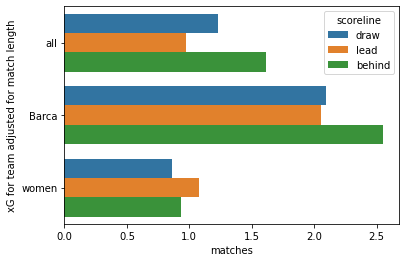

In [21]:
# Creating a bar plot from lead_xG_frame:
to_plot = pd.DataFrame({'matches': [value[0] for value in lead_xG_frame.values()],
                       'xG for team adjusted for match length': ['all', 'all', 'all', 'Barca', 'Barca', 'Barca', 'women', 'women', 'women'],
                       'scoreline': ['draw', 'lead', 'behind', 'draw', 'lead', 'behind', 'draw', 'lead', 'behind']})

print(sns.barplot(x='matches', y='xG for team adjusted for match length', hue='scoreline', data=to_plot))

In [22]:
xG_lead(Barca)

{'xG_diff_draw': (1.3200907758089147, 2.159296167639377),
 'xG_diff_leader_leading': (1.1529784363096582, 1.8669552426989366),
 'xG_diff_leader_behind': (1.384757582069307, 4.381848640678859),
 'xG_for_leader_draw': (2.163600966450365, 1.8815501164053003),
 'xG_for_leader_leading': (2.233721360113153, 1.3714274304396359),
 'xG_for_leader_behind': (2.513863964770297, 4.02598013624574),
 'xG_against_leader_draw': (0.8435101906414503, 0.8562236205329004),
 'xG_against_leader_leading': (1.0807429238034947, 0.9887386793134165),
 'xG_against_leader_behind': (1.12910638270099, 1.3238738132460275)}

In [23]:
xG_lead(women)

{'xG_diff_draw': (1.0477501163388145, 2.1799744522654834),
 'xG_diff_leader_leading': (0.6255267693748194, 1.81992940900729),
 'xG_diff_leader_behind': (2.065615767846743, 3.7540180666872116),
 'xG_for_leader_draw': (1.945446132633433, 1.8498199490379692),
 'xG_for_leader_leading': (1.6876670316602587, 1.2003564539769316),
 'xG_for_leader_behind': (2.629294901206897, 3.466531985241454),
 'xG_against_leader_draw': (0.8976960162946185, 0.9495080071902616),
 'xG_against_leader_leading': (1.0621402622854392, 1.11432926554582),
 'xG_against_leader_behind': (0.5636791333601532, 1.5650091310480427)}

In [24]:
# Creating a linear regression, showing the effect of leading time on xG diff performance:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def win_model(frame):
    points = np.array(frame[frame.winner != 'draw'][['event_key', 'winner_lead', 'diff_goal_diff_xG_diff']])
    
    X = points[:,1]
    y = points[:,2]
    
    X = X.reshape(-1, 1)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    xg_reg = LinearRegression()
    xg_reg.fit(X_train, y_train)
    print(xg_reg.score(X_test, y_test))

    print(xg_reg.score(X, y))
    print(xg_reg.coef_[0])
    print(xg_reg.intercept_)
    # Since the R^2 score is about 0.09, 9 percent of the goal xG difference can be explained by the leading time,
    # although there is a meaningful correlation between leading time and goal difference.

    y_pred = xg_reg.predict(X)

    plt.scatter(X, y)
    plt.plot(X, y_pred, color = 'red')
    plt.xlabel('minutes winner leading minus winner behind')
    plt.ylabel('goal diff minus xG diff')
    plt.show()

0.128766431505709
0.09094105064627955
0.012154147146062971
0.36425033453472355


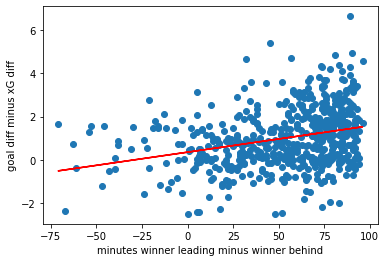

In [25]:
win_model(xG_frame)

0.008697503240692517
0.08456512731688381
0.013341014651722976
0.30801762447133485


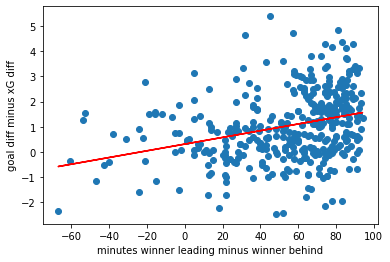

In [26]:
win_model(Barca)

0.18483520246537521
0.10077431437978257
0.010494480789674663
0.48354419863041964


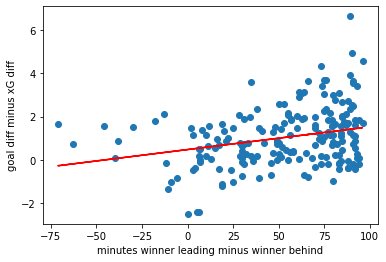

In [27]:
win_model(women)

In [28]:
# Compares xG per minute while leading or behind with xG per minute while draw:
winner_diff_leading_draw = 0
loser_diff_behind_draw = 0
diff_lead_draw = 0
num_matches = 0
list_winner_diff_leading_draw = []
list_loser_diff_behind_draw = []
list_diff_lead_draw = []

for i in xG_frame.index: # draws skipped because they are hard to compare with other matches
    if xG_frame.iloc[i].winner == xG_frame.iloc[i].home_team:
        if is_float(xG_frame.iloc[i].xG_home_team_per_min_lead_home_team - xG_frame.iloc[i].xG_home_team_per_min_draw):
            winner_diff_leading_draw += xG_frame.iloc[i].xG_home_team_per_min_lead_home_team - xG_frame.iloc[i].xG_home_team_per_min_draw
            list_winner_diff_leading_draw.append(xG_frame.iloc[i].xG_home_team_per_min_lead_home_team - xG_frame.iloc[i].xG_home_team_per_min_draw)
            loser_diff_behind_draw += xG_frame.iloc[i].xG_away_team_per_min_lead_home_team - xG_frame.iloc[i].xG_away_team_per_min_draw
            diff_lead_draw += xG_frame.iloc[i].xG_diff_per_min_home_team_lead - xG_frame.iloc[i].xG_diff_per_min_draw
            num_matches += 1
    elif xG_frame.iloc[i].winner == xG_frame.iloc[i].away_team:
        if is_float(xG_frame.iloc[i].xG_away_team_per_min_lead_away_team - xG_frame.iloc[i].xG_away_team_per_min_draw):
            winner_diff_leading_draw += xG_frame.iloc[i].xG_away_team_per_min_lead_away_team - xG_frame.iloc[i].xG_away_team_per_min_draw
            list_winner_diff_leading_draw.append(xG_frame.iloc[i].xG_away_team_per_min_lead_away_team - xG_frame.iloc[i].xG_away_team_per_min_draw)
            loser_diff_behind_draw += xG_frame.iloc[i].xG_home_team_per_min_lead_away_team - xG_frame.iloc[i].xG_home_team_per_min_draw
            diff_lead_draw += -(xG_frame.iloc[i].xG_diff_per_min_away_team_lead - xG_frame.iloc[i].xG_diff_per_min_draw)
            num_matches += 1

winner_diff_leading_draw /= num_matches
loser_diff_behind_draw /= num_matches
diff_lead_draw /= num_matches
print(winner_diff_leading_draw, loser_diff_behind_draw, diff_lead_draw)
print(np.std(list_winner_diff_leading_draw))

# Unfortunately, the standard deviation of list_winner_diff_leading_draw is > 6, which renders the statistic way too unstable.
# But the approach should work for a great dataset.

-1.7305605344913821 0.19401940619754177 -1.9245799406889244
6.199578836226853
